In [1]:
# iPython magic to autoreload modules everytime code is executed to propagate changes to the code
%load_ext autoreload
%autoreload 2

In [2]:
import coderdata as cd
from coderdata.utils.stats import summarize_response_metric
from coderdata.utils.stats import plot_response_metric

import matplotlib.pyplot as plt
import math
import os

In [3]:
os.mkdir('/tmp/coderdata')
os.chdir('/tmp/coderdata')

In [4]:
dataset_prefix = 'beataml'

In [5]:
cd.download_data_by_prefix(dataset_prefix)

Downloaded beataml_drugs.tsv.gz to local repository.
Downloaded beataml_proteomics.csv.gz to local repository.
Downloaded beataml_mutations.csv.gz to local repository.
Downloaded beataml_experiments.csv.gz to local repository.
Downloaded beataml_samples.csv to local repository.
Downloaded beataml_transcriptomics.csv.gz to local repository.


In [6]:
data = cd.DatasetLoader(dataset_prefix)
summary_stats = summarize_response_metric(data=data)
summary_stats

Processing Data...


,count,mean,std,min,25%,50%,75%,max
dose_response_metric,,,,,,,,
aac,23378.0,3.028061e-01,1.821265e-01,0.0000,0.166200,0.26375,0.415000,1.000000e+00
auc,23378.0,6.971939e-01,1.821265e-01,0.0000,0.585000,0.73625,0.833800,1.000000e+00
dss,23378.0,3.218484e-01,5.733492e-01,0.0000,0.000000,0.17750,0.346575,1.258000e+01
fit_auc,23378.0,5.530934e-01,2.074431e-01,0.0000,0.404000,0.53160,0.713500,2.667000e+00
fit_ec50,23378.0,5.113196e+00,2.553243e+00,-3.0000,4.534000,5.50350,6.675750,8.000000e+00
fit_ec50se,23378.0,5.279473e+08,6.163188e+10,0.0000,0.574600,1.55800,9.211500,9.117000e+12
fit_einf,23378.0,3.248612e-01,3.196515e-01,0.0000,0.000000,0.25620,0.611700,9.997000e-01
fit_hs,23378.0,-6.994430e-01,3.430275e-01,-1.0000,-1.000000,-0.88320,-0.396600,-0.000000e+00
fit_ic50,15622.0,6.404701e+00,3.819312e+00,-3.0000,5.460000,6.33700,7.024000,3.443000e+02


In [7]:
metrics = summary_stats.index.values

In [8]:
ncol = 3
nrow = math.ceil(len(metrics)/ncol)

Text(0.5, 0.98, 'Distribution of drug response values in "beataml"')

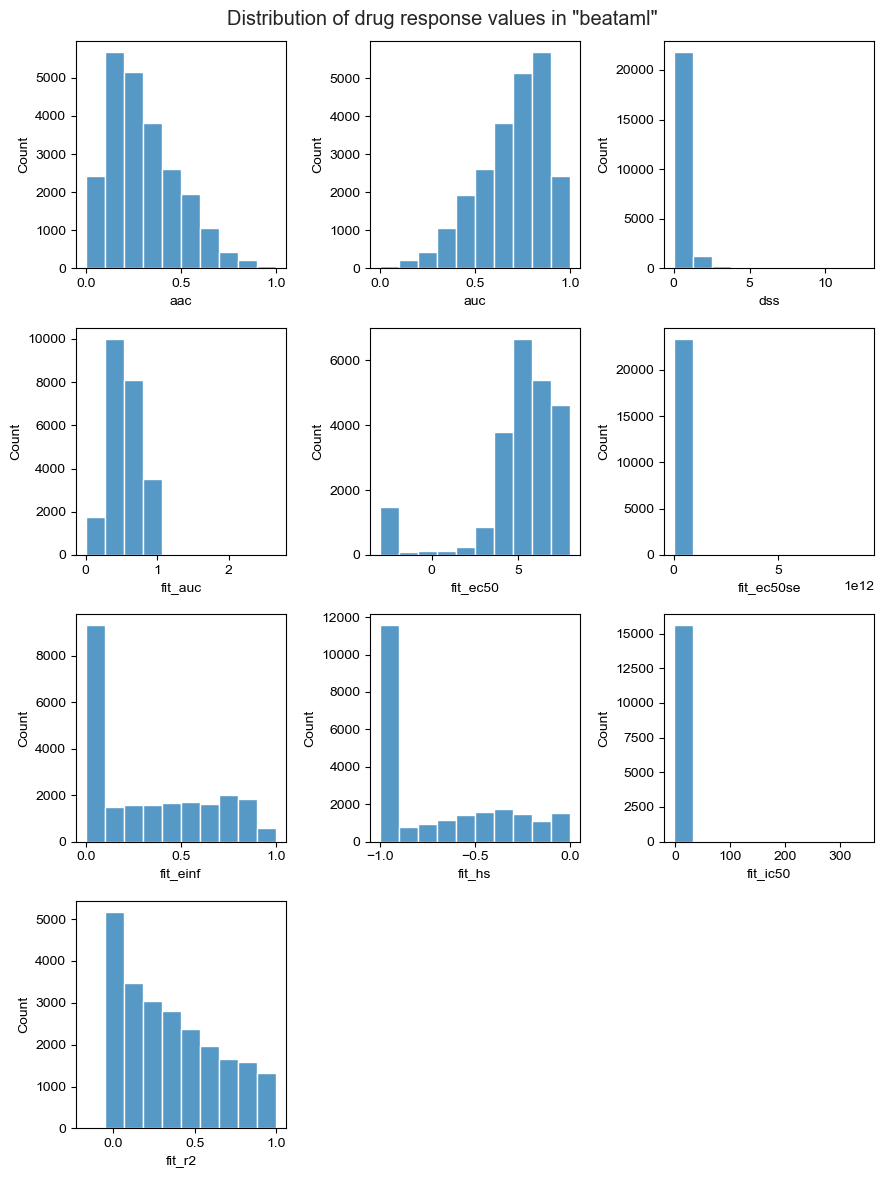

In [9]:
fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*3, nrow*3))

k = 0
for i in range(0, nrow):
    for j in range(0, ncol):
        if k < len(metrics):
            plot_response_metric(data=data, metric=metrics[k], bins=10, ax=axs[i, j])
        else:
            axs[i, j].axis('off')
        k += 1

fig.set_layout_engine('tight')
fig.suptitle(f'Distribution of drug response values in "{dataset_prefix}"')

# uncomment next line to save plot
# fig.savefig(f'{dataset_prefix}.png')